In [1]:
import gradio as gr
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images
from demo.cam import generate_gradcam, GradCAM
from captum.attr import LayerGradCam
from PIL import Image
from einops import rearrange

import numpy as np
import matplotlib.pyplot as plt
import os
import time

c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\transformers\models\auto\image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [2]:

model_path = "deepseek-ai/Janus-Pro-1B"
config = AutoConfig.from_pretrained(model_path)
language_config = config.language_config
language_config._attn_implementation = 'eager'
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path,
                                             language_config=language_config,
                                             trust_remote_code=True)

dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float16
# dtype = torch.bfloat32 if torch.cuda.is_available() else torch.float32

if torch.cuda.is_available():
    vl_gpt = vl_gpt.to(dtype).cuda()
else:
    # vl_gpt = vl_gpt.to(torch.float16)
    torch.set_default_device("mps")
    vl_gpt = vl_gpt.to(dtype)

vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer
cuda_device = 'cuda' if torch.cuda.is_available() else 'mps'

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: num_image_tokens, sft_format, add_special_t

In [8]:
def multimodal_understanding(image, question, seed, top_p, temperature):
    # Clear CUDA cache before generating
    torch.cuda.empty_cache()


    for param in vl_gpt.parameters():
        param.requires_grad = True
    
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    

    # Get the last transformer block of the Vision Transformer (ViT)


    conversation = [
        {
            "role": "<|User|>",
            "content": f"<image_placeholder>\n{question}",
            "images": [image],
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    
    pil_images = [Image.fromarray(image)]
    prepare_inputs = vl_chat_processor(
        conversations=conversation, images=pil_images, force_batchify=True
    ).to(cuda_device, dtype=dtype)
    


    
    # inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

    # print("prepared inputs", prepare_inputs)



    print("generating guided gradcam...")

    import torch.nn as nn

    class ViTForGradCAM(nn.Module):
        def __init__(self, vision_model, aligner, language_model):
            super().__init__()
            self.vision_model = vision_model
            self.aligner = aligner
            self.language_model = language_model

        def forward(self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            images_seq_mask: torch.LongTensor,
            images_emb_mask: torch.LongTensor,
            **kwargs,
            ):
            bs, n = pixel_values.shape[0:2]
            images = rearrange(pixel_values, "b n c h w -> (b n) c h w")
            images_embeds = self.aligner(self.vision_model(images))  # shape: [batch, T, D]
            
            # [b x n, T2, D] -> [b, n x T2, D]
            images_embeds = rearrange(images_embeds, "(b n) t d -> b (n t) d", b=bs, n=n)
            # [b, n, T2] -> [b, n x T2]
            images_emb_mask = rearrange(images_emb_mask, "b n t -> b (n t)")

            # [b, T, D]
            input_ids[input_ids < 0] = 0  # ignore the image embeddings
            inputs_embeds = self.language_model.get_input_embeddings()(input_ids)

            # replace with the image embeddings
            inputs_embeds[images_seq_mask] = images_embeds[images_emb_mask]

            return inputs_embeds


    # Wrap your vision model
    vit_scalar_model = ViTForGradCAM(vl_gpt.vision_model, vl_gpt.aligner, vl_gpt.language_model)
    target_layer = vit_scalar_model.vision_model.vision_tower.blocks[-1].norm1

    patch_scores = vit_scalar_model(**prepare_inputs)
    

    # # Compute the attributions.
    # gradcam = LayerGradCam(vit_scalar_model, target_layer)
    gradcam = GradCAM(vit_scalar_model, target_layer)
    cam_tensor = gradcam(prepare_inputs, target_token_idx=0)
    
    # attribution = gradcam.attribute(images)

    # saliency_map = generate_gradcam(attribution, pil_images[0])
    # plt.imshow(saliency_map)
    # plt.show()
    return patch_scores, cam_tensor

In [9]:
# IMG_PATH = "../images/equation.png"
IMG_PATH = "../images/doge.png"

image = Image.open(IMG_PATH)
image_arr = np.array(image)
question = "explain this meme."
patch_scores, cam_tensor = multimodal_understanding(image_arr, question, 100, 0.95, 0.1)


generating guided gradcam...


In [10]:
patch_scores_arr = patch_scores.detach().to(float).to("cpu").numpy()
patch_scores_arr.shape

(1, 628, 2048)

In [11]:
cam_tensor_arr = cam_tensor.detach().to(float).to("cpu").numpy()
cam_tensor_arr.shape

(1, 576)

Generating Grad-CAM with attributions shape: torch.Size([24, 24])


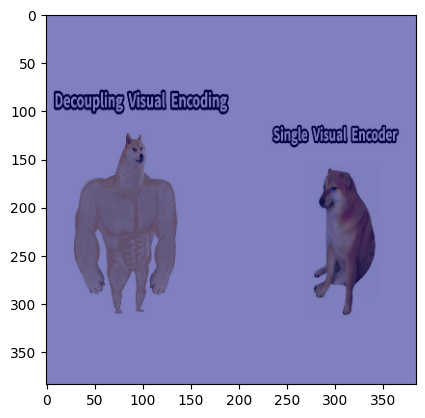

In [12]:
cam_grid = cam_tensor.reshape(24, 24)  # removing batch dimension later if needed


cam = generate_gradcam(cam_grid, image)

plt.imshow(cam)
plt.show(cam)

In [14]:
cam_arr = cam_grid.detach().to(float).to("cpu").numpy()
cam_arr

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 